# TP : Résolution de l'équation de Vlasov-Poisson 1D-1D par une méthode semi-lagrangienne

In [1]:
# Basic imports 
import numpy as np 
import matplotlib.pyplot as plt 

On s'intéresse à l'équation de Vlasov  (évolution de la distribution des électrons dans un plasma) couplée avec l'équation de Poisson (évolution du champ électrique). 

\begin{equation}
\begin{cases}
\partial_t f + v \,\partial_x f - E(x,t) \,\partial_v f = 0 \\ 
\\ 
\partial_x E = \rho(x,t) = 1 - \int f(x,v,t) \,dv 
\end{cases}
\end{equation} 


## Discrétisation de l'espace des phases 

On considère un espace des phases en deux dimensions (une d'espace et une de vitesse) $\Omega = (-\pi, \pi)^2 \subset \mathbb{R}^2$ que l'on va discrétiser par une grille uniforme $\mathcal{M} = \{(x_i, v_j)\}_{i= 0\,, \cdots, \,n_x-1\,,\,j=0\,, \cdots,\, n_v-1, }\subset \Omega$ 

In [468]:
nx = 2**10; nv = 2**10
dt = 1e-2
a = np.pi   
vmax = np.pi 
x = np.linspace(-a, a, num=nx, dtype=float)
v = np.linspace(-vmax, vmax, num=nv, dtype=float)
xx, vv = np.meshgrid(x,v) 
T = 10 

In [469]:
k_values = np.arange(-nx//2, nx//2) 
l_values = np.arange(-nv//2, nv//2) 

## Condition initiale 

On se donne une condition initiale en distribution de particules $f_0(x,v)$ 

In [405]:
f = lambda x, v : (1 / 2*np.pi)*np.exp(-0.5*(x**2+v**2))

In [377]:
f_per = lambda x, v : np.sin(3*x) + np.cos(2*v) + np.sin(5* x)  

Text(0, 0.5, '$v$')

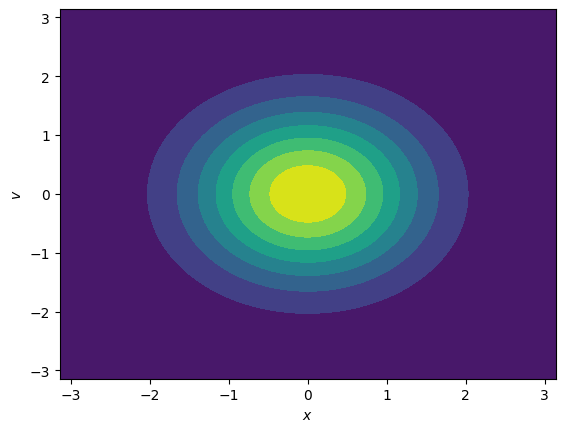

In [406]:

f_zero = f(xx, vv)
plt.contourf(x, v, f_zero)
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')  

## Résolution de  l'équation de Poisson

La partie poisson du problème s'écrit 

\begin{equation}
\tag{P}
\partial_x E = \rho(x,t) = 1 - \int f(x, v, t) \,\text{d}v
\end{equation}

On va résoudre ce problème en discrétisant $f$ en modes de Fourier selon 
$$ f^n(x,v) = f(x,v, t_n) = \frac{1}{4\pi^2} \sum\limits_{k,l} c^n_{k,l} \, e^{i k.x} e^{i l.v} $$
Ainsi 
\begin{align*}
\rho^n(x, v) & = 1 - \frac{1}{4\pi^2} \sum\limits_{k,l} c^n_{k,l} \, e^{i k.x} \underbrace{\int e^{i l.v} \,\text{d}v}_{=0 \text{ si } l\neq 0 \text{ et } 2\pi \text{ sinon}} \\ 
             & = 1 - \frac{1}{2\pi}\sum\limits_{k} c^n_{k,0} \, e^{i k.x}  \\ 
             & = \sum\limits_{k} \tilde{c_k}^n \, e^{i k.x},         
\end{align*}
en posant $$\tilde{c_k}^n = 
            \begin{cases} 
                1 - \frac{1}{2\pi}\,c^n_{k,0} & \text { si } k=0 \\
                - \frac{1}{2\pi}c^n_{k,0} & \text{ sinon.}
            \end{cases} 
            $$
On écrit la somme de Fourier pour le champ électrique : 
$$ E^n(x) = \frac{1}{2\pi} \sum\limits_{j} d_j^n \, e^{i j.x} $$ 
donc 
$$ \frac{\text{d} E^n}{\text{d} x} = \frac{1}{2\pi} \sum\limits_{j} i j\, d_j^n \, e^{i j.x} $$

et par identification (unicité) des coefficients de Fourier on obtient $d_k^n =2\pi\,\frac{\tilde{c_k}^n}{ik} \text{ pour } k\neq 0$. La valeur de $d_0^n$ qui correspond à la moyenne du champ électrique peut être choisie librement et on prendra par exemple $d_0^n=0$.

## Calcul des coefficients de fourier et approximation de la série 

On considère une fonction $f$ $2\pi$-périodique définie sur $(-\pi, \pi)$ d'une variable $x$ 1D dont on cherche à calculer les coefficients de Fourier seulement à partir de sa connaissance sur une grille discrétisée $\{x_l\}_{l=0, \,\cdots,\, n_x-1}$.

Le $k$-ème coefficient de Fourier de $f$ noté $c_k$ est défini par 

$$ c_k = \int_{-\pi}^{\pi} f(x) e^{-ikx} \text{d}x .$$ 

Nous allons approcher ces coefficients à partir de notre discrétisation de l'espace des phases en $x$ avec une somme de Riemman selon : 

$$ c_k^{n_x}= \frac{2\pi}{n_x}\sum\limits_{l=0}^{n_x-1} f_l \, e^{-ik\,x_l} \underset{n_x \to +\infty}{\longrightarrow} c_k .$$ 

Avec $\frac{2\pi}{n_x} = \Delta x$, l'incrément en $x$.

La fonction $f$ est donc approchée par sa série de fourier (où les coefficients de Fourier sont approchés selon ce qui précède) 

$$ f(x) \sim \sum\limits_{k\in\mathbb{Z}} c_k^{n_x} \,e^{ik.x}. $$ 

On introduit ainsi une nouvelle étape de discrétisation en tronquant cette somme de Fourier afin de reconstruire la fonction numériquement. Soit donc $K\in \mathbb{N}^*$ tel qu'on fait l'approximation 

$$ f(x) \sim \sum\limits_{k = 0}^{K-1} c_k^{n_x} \, e^{ik.x}.$$ 



On s'intéresse ainsi au calcul des coefficients $c_k$ pour $k= 0, \,\cdots,\, K-1$ et l'on voit que l'on peut écrire le calcul sous forme matricielle selon : 

 
$$
\begin{pmatrix}
c_{0} \\
\vdots \\ 
c_{K-1}
\end{pmatrix}
= 
\frac{2\pi}{n_x} 
\tilde{F}
\begin{pmatrix}
f_0 \\ 
\vdots \\ 
f_{n_x -1} 
\end{pmatrix}
,
$$

Où $\tilde{F}\in \mathbb{R}^{K \times n_x}$ est la matrice définie par 
$$ \tilde{F} = [ \,e^{-ik\,x_l}\, ]_{k = \, 0, \cdots, \,K-1 ;\, l=\,0, \cdots,\, n_x-1}.$$ 

In [6]:
k_values = np.arange(-nx//2, nx//2) 

In [7]:
import itertools as it 

In [8]:
def build_F_tilde(x, k_values):
    nx = len(x) 
    F_tilde = np.array([np.exp(-k*1j * x[l]) for k,l in it.product(k_values, range(nx))], dtype=complex)
    F_tilde.resize((2*K+1,nx)) 
    return F_tilde

def fourier_coeffs_1D(x, f, F_tilde):
    nx = len(x) 
    c = ((2 * np.pi) / nx) * (F_tilde @ f) 
    return c

On écrit une fonction qui reconstruit une fonction en calculant sa série de fourier tronquée à partir de ses coefficients de fourier 

In [9]:
def fourier_coeffs(x, k_values, f):
    nx = len(x) 
    c_fft = np.fft.fft(f)
    c_shifted = np.fft.fftshift(c_fft) 
    coeffs = np.array(
        [coeff_shifted * np.exp(1j*k*np.pi) 
        for coeff_shifted, k in zip(c_shifted, k_values)]
    )
    return coeffs

In [10]:
def fourier_rec(x, k_values, c):
    nx = len(x)
    reconstruction = (1/nx) * np.array(
        [np.sum(
            [coeff * np.exp(1j*k*x[n]) for coeff, k in zip(c, k_values)]
        )
        for n in range(nx)]
    )
    return reconstruction

In [11]:
def fourier_interpolator(x, k_values, c):
    nx = len(x)
    reconstruction = lambda _x: (1/nx) * np.sum(
            [coeff * np.exp(1j*k*_x) for coeff, k in zip(c, k_values)]
        )
    return reconstruction

In [12]:
def fourier_series(x, k_values, c):
    s = lambda x: (1 / (2*np.pi)) * np.sum(
        [coeff*np.exp(1j*k*x) 
    for k, coeff in zip(k_values, c)]
    )
    return np.array([s(_x) for _x in x]) 

In [444]:
g = lambda x : np.sin(x) + np.sin(2*x) + np.cos(x) 
g_h = np.array(list(map(g,x)))

In [445]:
c = fourier_coeffs(x, k_values, g_h) 

In [446]:
_int = fourier_interpolator(x, k_values, c) 

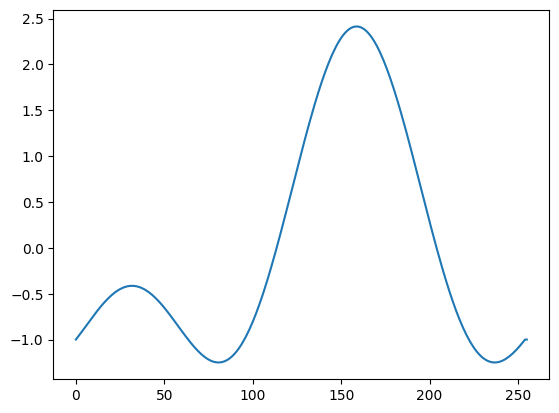

In [447]:
plt.plot(list(map(_int, x)))

In [310]:
new_x = np.linspace(-3*np.pi, 3*np.pi, 3*nx) 

In [311]:
extended_int = list(map(_int, new_x)) 

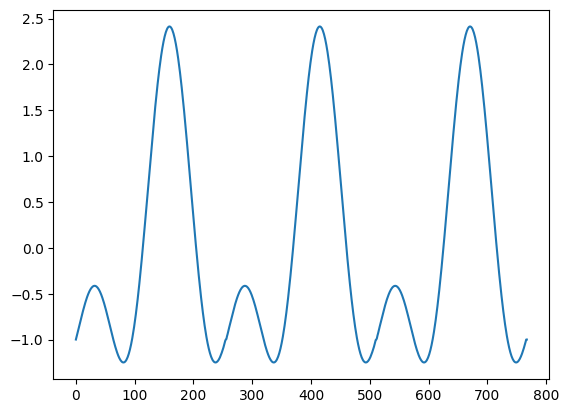

In [312]:
plt.plot(extended_int) 

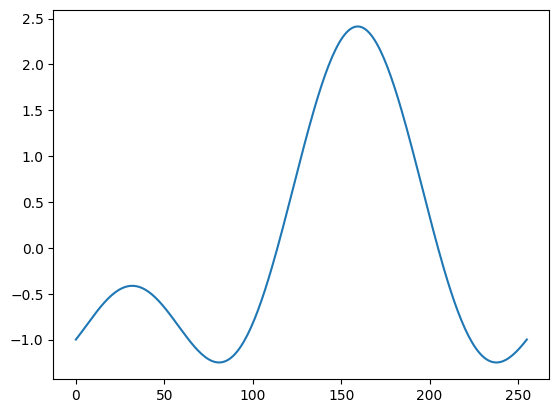

In [313]:
plt.plot(g_h) 

In [314]:
rec = fourier_rec(x, k_values, c) 

In [315]:
list(map(_int, x)) == rec 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

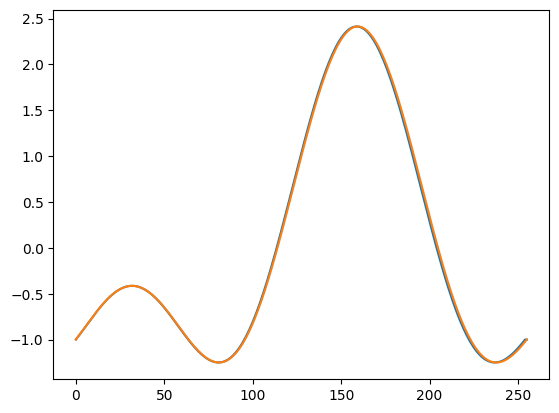

In [316]:
plt.plot(rec)
plt.plot(g_h) 

## Calcul des modes en $l=0$ 

Pour la résolution de l'équation de Poisson nous avons vu que nous étions intéressé par les coefficients de fourier 

$$c_{k,0}(f) = \int_{(-\pi, \pi)^2} f(x,v) \, e^{-i k .x} \,\text{d}x\,\text{d}v.$$ 

Nous les approchons numériquement de manière classique avec des sommes de Riemann : 

\begin{align*}
c_{k,0}(f) \sim & \Delta x\,\Delta v \sum\limits_{m=0}^{n_x -1}\sum\limits_{n=0}^{n_v -1} f[m, n]\, e^{-ik.x_m} \\
\sim & \frac{4\pi^2}{n_x\,n_v} \sum\limits_{m=0}^{n_x -1}\sum\limits_{n=0}^{n_v -1} f[m, n]\, e^{-ik.x_m},
\end{align*}  

Où l'on a écrit $\Delta x = \frac{2\pi}{n_x}$ et $\Delta v = \frac{2\pi}{n_v}$.  

In [250]:
def fourier_coeff_2D(x, v, f):
    nx = len(x); nv=len(v)
    c_fft = np.fft.fft2(f) 
    c = ((4*np.pi**2) / (nx*nv)) * np.array(
        [np.exp(k*1j*np.pi)*np.exp(l*1j*np.pi) * c_fft[l,k]
        for l,k in np.ndindex((nv,nx))]
        )
    c.resize((nv,nx)) 
    return c

In [251]:
def fourier_reconstuction(x, k_values, c):
    s = lambda x: (1 / (2*np.pi)) * np.sum([coeff*np.exp(1j*k*x) 
    for k, coeff in zip(k_values, c)])
    rec_arr = np.array(list(map(s, x))) 
    return rec_arr 

In [26]:
# def coeff_l_zero(x, v, k, f):
#     nx = len(x); nv=len(v) 
#     return (
#         (4 * np.pi**2) / (nx * nv)) * np.sum([f[n,m] * np.exp(-1j*k*x[m]) 
#     for n,m in np.ndindex((nv, nx))]
#     )

# def coeffs_l_zero(x, v, k_values, f):
#     return np.array([coeff_l_zero(x, v, k, f) for k in k_values])

## Code pour la résolution de Poisson 

Tous les éléments sont ainsi en place afin de résoudre l'équation de Poisson grâce aux séries de fourier 

In [27]:
# def solve_poisson(x, v, k_values, f):
#     K = len(k_values)
#     nx = len(x) 
#     c = coeffs_l_zero(x, v, k_values, f)
#     c_tilde = np.zeros(K, dtype=complex)
#     c_tilde[0] = 1 - (1/(2*np.pi)) * c[0] 
#     for k in range(1, K):
#         c_tilde[k] = - (1/(2*np.pi)) * c[k]      
#     d = np.zeros(K, dtype=complex)
#     # Electric field mean has to be fixed
#     d[0] = 0 
#     for k in range(1, K):  
#         d[k] = 2*np.pi * (c_tilde[k]) / (k*1j)
#     _E = fourier_series(x, k_values, d)
#     return _E

In [283]:
def solve_poisson(x, v, f):
    nx = len(x); nv = len(v) 
    c = fourier_coeff_2D(x, v, f)
    c_tilde = np.zeros(nx, dtype=complex)
    c_tilde[0] = 1 - c[0,0] 
    for k in range(1, nx):
        # 0-mode in v : c[0,:]
        c_tilde[k] = - c[0,k]        
    d = np.zeros(nx, dtype=complex)
    # Electric field mean has to be fixed, we choose 0 
    d[0] = 0 
    for k in range(1,nx):  
        d[k] = 2*np.pi *(c_tilde[k]) / (k*1j)
    _E = fourier_reconstuction(x, range(nx), d) 
    return (1/np.pi) * _E

In [29]:
# def solve_poisson_2D_noshift(x, v, k_values, l_values, f):
#     K = len(k_values)
#     nx = len(x) 
#     c = fourier_coeffs_2D_no_shift(x, v, k_values, l_values, f)
#     c_tilde = np.zeros(K, dtype=complex)
#     c_tilde[0] = 1 - c[0,0] 
#     for k in range(1, K):
#         c_tilde[k] = - c[0,k]      
#     d = np.zeros(K, dtype=complex)
#     # Electric field mean has to be fixed
#     d[0] = 0 
#     for k in range(1, K):  
#         d[k] = 2*np.pi * (c_tilde[k]) / (k*1j)
#     _E = fourier_rec(x, k_values, d)
#     return _E

In [336]:
E_zero = solve_poisson(x, v, f_zero)

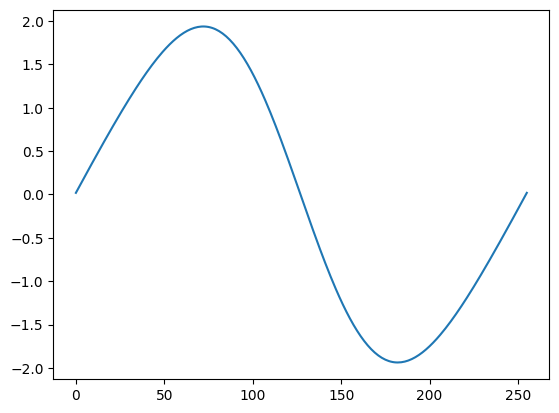

In [337]:
plt.plot(np.real(E_zero)) 

## Comparaison à une méthode éléments finis pour Poisson 

In [286]:
dx = 2*np.pi / nx; dv = 2*np.pi / nv 

In [287]:
def compute_rho(x, dv, f):
    nx = len(x) 
    rho =  1 - dv * np.array(
        [np.sum(f[:,j]) 
        for j in range(nx)
        ]
    )
    return rho 

In [288]:
def build_diff_matrix(x, dx):
    nx = len(x) 
    m = np.zeros((nx,nx)) 

    for i in range(1, nx-1):
        m[i,i+1] = 1 
        m[i,i-1] = -1 
    
    m[0,1] = 1; m[0,-1] = -1 
    m[-1,0] = 1; m[-1, -2] = -1 

    return (1/(2*dx)) * m 

def build_diff_matrix_uncentered(x, dx):
    nx = len(x) 
    m = np.zeros((nx,nx)) 

    for i in range(nx-1):
        m[i,i+1] = 1 
        m[i,i] = -1
    
    m[-1,0] = 1; m[-1,-1] = -1 

    return (1/dx) * m     

In [289]:
def solve_poisson_centered(x, dx, dv, f):
    rho = compute_rho(x, dv, f)
    m = build_diff_matrix(x, dx) 
    E = np.linalg.pinv(m) @ rho 
    return E 

def solve_poisson_uncentered(x, dx, dv, f):
    rho = compute_rho(x, dv, f)
    m = build_diff_matrix_uncentered(x, dx) 
    E = np.linalg.pinv(m) @ rho 
    return E 


In [290]:
E_poisson = solve_poisson_centered(x, dx, dv, f_zero) 

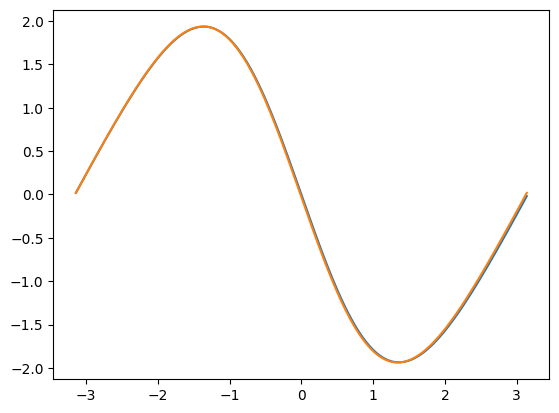

In [291]:
plt.plot(x, E_poisson) 
plt.plot(x, E_zero)

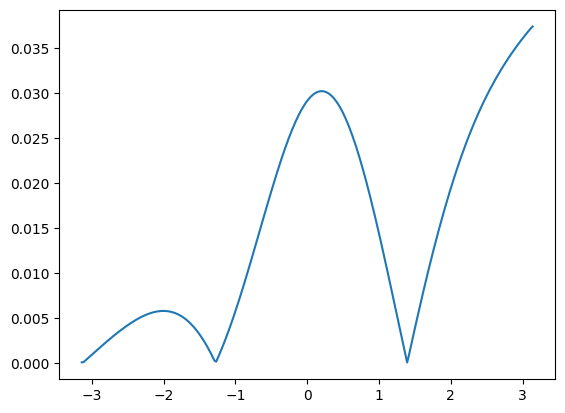

In [292]:
plt.plot(x, np.abs(E_poisson - np.real(E_zero)))

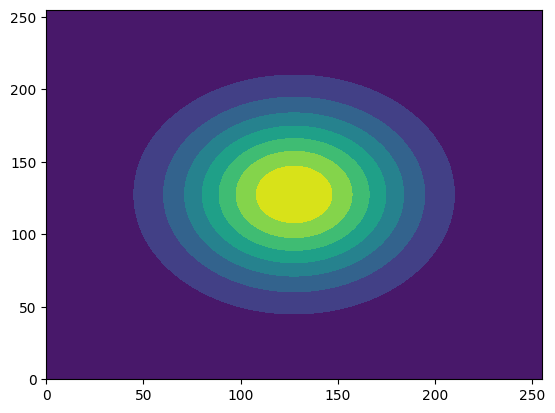

In [293]:
plt.contourf(f_zero) 

## Phénomènes de transport dans l'équation de Vlasov


L'équation de Vlasov peut être décomposée en deux phénomènes décrivant son évolution :
- une advection en $v$ causée par le champ $E$ : 

\begin{equation}
\tag{a}
\partial_t f - E(x,t) \, \partial_v f = 0 
\end{equation}

- une advection en $x$ causée par le champ de vitesses : 

\begin{equation}
\tag{b}
\partial_t + v \,\partial_x f = 0
\end{equation}

Ces équations sont des équations de transport, dont les solutions analytiques peuvent être obtenues en appliquant la "méthode des caractéristiques".


### Méthode des caractéristiques



On considère une équation de transport 1D homogène à une dimension avec champ de vitesse $a(x,t)$: 

\begin{equation}
\tag{T}
\partial_t u + a(x,t)\,\partial_x u = 0
\end{equation}

Soit $(t,x) \in \mathbb{R}^{+} \times \mathbb{R}$ et  $X(s;t,x), s\in \mathbb{R}$ une courbe paramétrée lisse telle que $X(t;t,x) = x$.

On effectue le calcul de $\frac{d}{ds}u(X(s;t,x), t)$. 

\begin{align*} 
    \frac{\text{d}}{\text{d}s}u(X(s;t,x), s) = \partial_t u(X(s;t,x), s) + \frac{\text{d}X}{\text{d}s}(s;t,x)\, \partial_x u(X(s;t,x),s) & \quad \text{ (règle de la chaine)} 
\end{align*} 

On voit donc avec $(\text{T})$ que cette égalité se réduit à zéro si on impose la condition 

\begin{equation}
\tag{C}
\frac{\text{d}X}{\text{d}s} (s; t,x) = a(X(s;t,x),s) 
\end{equation}

On a ainsi réduit la résolution de l'EDP $(\text{T})$ à la résolution de l'EDO $(\text{C})$ dite "équation des caractéristiques". 


Dans le cas simple où le champ de vitesses $a$ est constant, l'équation $(\text{C})$ s'intégre en 
$$X(s;t,x) = as + b$$ 

et le coefficient b est déterminé par la condition

$$X(t;t,x) = x \implies b = x - at$$ 

de sorte que 

$$X(s;t,x) = x + a(s-t).$$

L'intérêt d'imposer l'équation des caractéristiques $\text{(C)}$ est de fixer 

$$\frac{\text{d}}{\text{d}s}u(X(s;t,x), s)= 0$$

et ainsi $\textbf{la solution est constante le long des courbes caractéristiques}$ de sorte que pour tout $(x,t)$

$$u(x,t) = u(X(t;t,x), t) = u(X(0;t,x), 0) = u_0(x-at)$$ 

où $u_0(x) = u(x, t=0)$ est la condition initiale. 



On voit ainsi ques les équations $(a)$ et $(b)$ sont analytiquement résolues par 

\begin{equation}
\tag{a*}
    f(x,v,t) = f_0(x, v + E(x)\,t)
\end{equation}
et
\begin{equation}
\tag{b*}
    f(x,v,t) = f_0(x - v\,t, v)
\end{equation}
respectivement. 

Seulement dans notre cas où l'on cherche à résoudre l'équation de Vlasov-Poisson (où l'évolution du champ électrique $E$ est couplée à l'équation de Vlasov) nous faison face à deux difficultés : 

1) Quel champ $E$ utiliser dans l'étape d'advection en $v$ ? Celui-ci évolue en effet simultanément par rapport à $f$. Cette question va nous amener à définir un schéma de $\textbf{splitting}$.
2) Les points $x-v\,t$ ou $v + E(x)\,t$ n'ont aucune raison particulière d'appartenir au maillage $\mathcal{M}$. Ce qui va nous amener à définir une étape $\textbf{d'interpolation}$ dans le schéma. 

## Interpolation en séries de Fourier 

On suppose connus la décomposition en série de fourier tronquée de $f$ à l'étape $n$ selon : 

$$ f^n(x, v) = \frac{1}{2\pi}\sum\limits_{k= 0}^{K-1}\sum\limits_{l = 0}^{L-1} c_{k,l}^n \, e^{i k.x}e^{i l.v} $$ 

L'interpolation consiste ainsi à évaluer cette expression aux points d'interpolation $x - v\Delta t$ ou $v + E(x)\frac{\Delta t}{2}$ par exemple. 

## Calcul des coefficients de fourier en 2D 

On voit ainsi qu'on a besoin de calculer les coefficients de fourier de $f$ dans les deux dimensions $(x,v)$ pour réaliser l'interpolation. On introduit donc de même le paramètre $L$.

In [204]:

l_values = np.arange(-nv//2, nv//2) 

De manière similaire à ce qui a été fait en dimension 1 on calcule les coefficients de fourier en 2D en résolvant un système matriciel qui peut s'écrire : 

$$ 
\begin{pmatrix}
c_{0, 0} &  \cdots & c_{0, K-1} \\ 
\vdots   & & \vdots \\ 
c_{L-1, 0} & \cdots & c_{L-1, K-1} 
\end{pmatrix}
= 
\frac{4\pi^2}{n_x\,n_v}
\tilde{F}^{2D} : 
\begin{pmatrix}
f_{0,0} & \cdots & f_{0, n_v-1} \\ 
\vdots &  & \vdots \\ 
f_{n_x -1, 0} & \cdots & f_{n_x-1, n_v-1} 
\end{pmatrix}
$$

Où $\tilde{F}^{2D}\in\mathbb{R}^{l \times k \times n_x \times n_v}$ est le tenseur d'ordre 4 défini par 

$$ \tilde{F}^{2D} = [ e^{-ik.x_n}e^{-il.v_m}]_{\,l,k,,m,n}  \quad l=0, \cdots, L-1;k=0,\cdots,K-1;\, \, m=0,\cdots, n_x-1;\, n=0, \cdots, n_v-1$$ 



In [186]:
def build_F_tilde_2D(x, v, k_values, l_values):
    K = len(k_values) ; L = len(l_values) 
    nx = len(x) ; nv = len(v) 
    F_tilde = np.array(
        [ np.exp(-k*1j*x[m])*np.exp(-l*1j*v[n]) 
        for l,k,m,n in it.product(l_values, k_values,range(nx), range(nv))]
        , dtype=complex
        ).reshape((L, K, nx, nv))  
    return F_tilde



In [187]:
def fourier_coeffs_2D_tensor(x, v, f, F_tilde):
    return ((4*np.pi**2) / (nx*nv)) * np.tensordot(F_tilde, f) 

## Complexité trop élevée : introduction de la FFT

La FFT (pour Fast Fourier Transform) est un des algorithmes les plus utilisés de nos jours en ceci que - comme son nom l'indique - il permet d'effectuer une transformée de Fourier (Discrète) très rapidement.

Plus exactement sa complexité est un $O(N\log(N))$ 
contre $O(N^2)$
pour la transformée de Fourier "naïve".

In [188]:
c_fft = np.fft.fft2(f_zero) 

Par définition la $\text{FFT}$ calcule la transformée de Fourier discrète du vecteur $f = [f[n]]_{n = 0, \cdots, N-1}$ selon 

$$ \text{FFT}(f)[k] = \sum\limits_{n = 0}^{N-1} f[k] \, e^{-2i\pi kn / N} .$$ 

Ici, on considère un vecteur **échantillonné** $\{f[n]\}_{n = 0, \cdots, n_x-1}  = \{f(x_n)\}$ où $x_n = -\pi + n\Delta x$ avec $f$ une fonction de la variable $x\in (-\pi, \pi)$. 

Or, nous sommes intéressés par le calcul des coefficients $c_k$ dans la série de Fourier de $f$, nous allons ainsi exprimer l'approximation en somme de Riemman de $c_k$ pour faire apparaître le terme $\text{FFT}(f)[k]$. 

\begin{align*}
    x_k(f) = \mathcal{F}(f)(k) & = \int_{(-\pi, \pi)} f(x)\, e^{-ik.x} dx \\
                                & \sim \Delta x \, \sum\limits_{n=0}^{n_x-1} f(x_n)\,e^{-ik.x_n} \quad \text{(Riemann)} \\ 
                                & \sim \frac{2\pi}{n_x} e^{ik\pi} \sum\limits_{n=0}^{n_x-1} f[n]\,e^{-2i\pi kn / n_x} \\ 
                                & \sim \frac{2\pi}{n_x} e^{ik\pi} \text{FFT}(f)[k].
\end{align*}

On obtient ainsi les coefficients dans la série de fourier de $$ pour k = 0, \cdots, n_x-1$, et l'extension à $f$ définie sur deux dimensions $(x,v)\in (-\pi, \pi)^2$ pour notre cas est naturelle : 

$$ c_{k,l}(f) \sim \frac{4\pi^2}{nx\, nv} e^{ik\pi} e^{il\pi}\,\text{FFT2}(f)[l,k] \quad \text{pour} \quad l = 0, \cdots, n_v-1; k = 0, \cdots, n_x-1$$

**Remarque importante** : On voit ainsi qu'afin d'utiliser la FFT, il nous est imposé de choisir $K=n_x$, $L=n_v$ dans la discrétisation en séries de Fourier. 

In [189]:
l_values = np.arange(-nv//2, nv//2)

In [190]:
# def fourier_coeffs_2D_no_shift(x, v, k_values, l_values, f):
#     nx = len(x); nv = len(v) 
#     c_fft = np.fft.fft2(f) 
#     coeffs = np.array(
#         [
#             np.exp(1j*k*np.pi) * np.exp(1j*l*np.pi) * c_fft[l,k] 
#             for l,k in it.product(range(nv), range(nx)) 
#         ]
#     ).reshape((nv,nx)) 
#     return coeffs 

In [191]:
# c = fourier_coeffs_2D_no_shift(x, v, k_values, l_values, f_zero) 

In [192]:
def fourier_coeffs_2D(x, v, k_values, l_values, f):
    nx = len(x); nv = len(v) 
    K = len(k_values); L = len(l_values) 
    c_fft = np.fft.fft2(f) 
    c_shifted = np.fft.fftshift(c_fft) 
    coeffs = np.array(
        [c_shifted[l+nv//2, k+nx//2] * np.exp(1j*k*np.pi) * np.exp(1j*l*np.pi)
        for l,k in it.product(l_values, k_values)]
    ).reshape((L,K))
    return coeffs 

def fourier_rec_2D(x, v, k_values, l_values, c):
    nx = len(x); nv = len(v) 
    reconstruction = (1/(nx*nv)) * np.array([
        np.sum(
            [c[l+nv//2, k+nx//2] * np.exp(1j*k*x[n]) * np.exp(1j*l*v[m])
            for l,k in it.product(l_values, k_values)]
            )
            for m,n in np.ndindex((nv,nx))]
    ).reshape((nv,nx))
    return reconstruction

def fourier_interpolation_2D(x, v, k_values, l_values, c):
    nx = len(x); nv = len(v) 
    interpol = lambda _xv, : (1/(nx*nv)) * np.sum(
        [c[l+nv//2, k+nx//2] * np.exp(1j*k*_xv[0]) * np.exp(1j*l*_xv[1])
        for l,k in it.product(l_values, k_values)]
        )
    return interpol

In [193]:
c = fourier_coeffs_2D(x, v, k_values, l_values, f_zero) 
rec = fourier_rec_2D(x, v, k_values, l_values, c)
interpol = fourier_interpolation_2D(x, v, k_values, l_values, c) 

KeyboardInterrupt: 

False

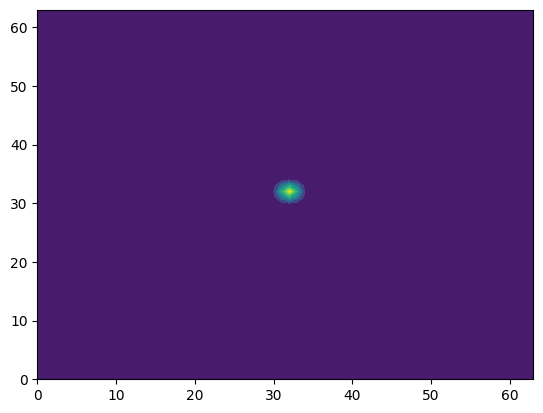

In [ ]:
plt.contourf(np.abs(c)) 
_rec = np.array([interpol((x[j], v[i])) for i,j in np.ndindex((nv,nx))]).reshape((nv,nx)) 
np.any(_rec != rec)  

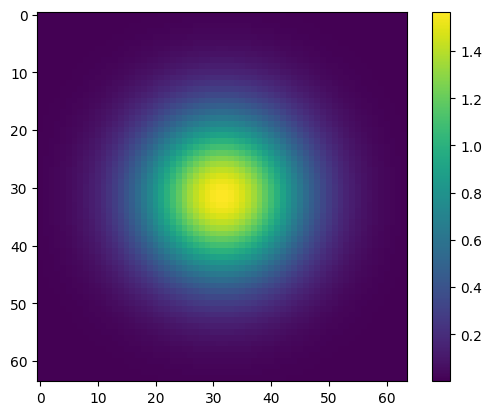

In [ ]:
plt.imshow(f_zero) 
plt.colorbar()

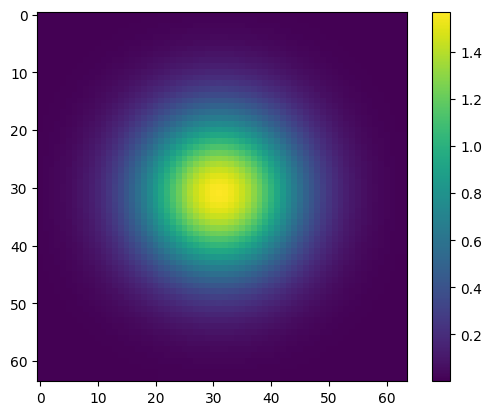

In [ ]:
plt.imshow(np.real(rec))
plt.colorbar()  

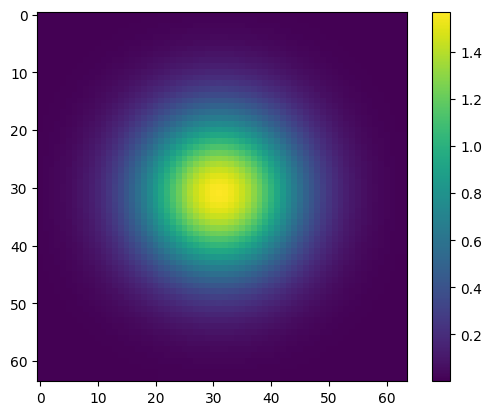

In [ ]:
plt.imshow(np.real(_rec)) 
plt.colorbar() 

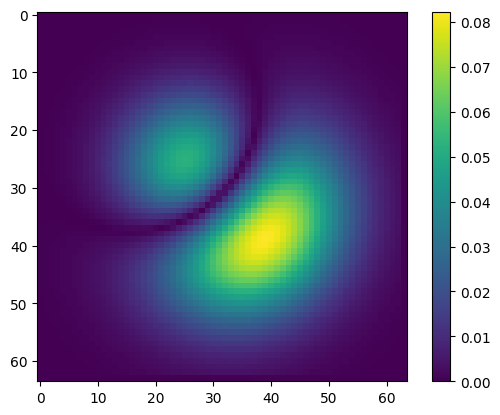

In [ ]:
plt.imshow(np.abs(f_zero-np.real(rec)))
plt.colorbar() 

## Schéma de Splitting semi-lagrangien

Nous détaillons ici le schéma de splitting que nous allons mettre en place pour la résolution du système de Vlasov-Poisson. 

1. $\textbf{Initialisation}$ : On se donne une condition initiale $f_0$, avec laquelle on calcule le champ initial $E_0$ en résolvant $(\text{P})$
2. $\textbf{Itération}$ : 
    - A partir de $(E^n, \,f^n)$ calculés à l'étape $n$ on calcule l'advection en $v$ sur un demi pas de temps $f^*(x,v) = f^n(x, v + E^n(x)\,\frac{\Delta t}{2})$ qui est solution de
        $$ \partial_t f - E^n(x)\,\partial_v f = 0.$$
        Les valeurs de $f^*$ étant obtenues par interpolation de $f^n$ selon la dimension $v$.

    - A partir de $f^*$ on calcule l'advection en $x$ sur un pas de temps complet $f^{**}(x,v) = f^*(x - v\,\Delta t, v)$ qui est solution de 
        $$ \partial_t f + v \,\partial_x f = 0.$$ 
        Les valeurs de $f^{**}$ étant également obtenues par interpolation de $f^{*}$ selon la dimension $x$.

    - On calcule le nouveau champ électrique $E^{n+1}(x)$ en résolvant $(\text{P})$ à partir de la distribution $f^{**}$.
    
    - Enfin, on effectue une dernière advection également avec une étape d'interpolation en $v$ à partir du nouveau champ électrique et de $f^{**}$ pour obtenir $f^{n+1}(x,v) = f^{**}(x, v+E^{n+1}(x)\,\frac{\Delta t}{2})$ qui est solution de 
        $$ \partial_t f - E^{n+1}(x)\,\partial_v f = 0.$$ 
    
    - On stocke $(f^{n+1}, \,E^{n+1})$.


## Interpolation 1D 

On voit ainsi dans le schéma qu'il n'est nécessaire de réaliser des interpolations qu'en une dimension selon si l'on souhaite calculer l'advection en $x$ ou en $v$ 

In [317]:
def x_fourier_interpolator(x, k_values, f, i):
    # fixed v = v[i]
    _f = f[i,:] 
    c = fourier_coeffs(x, k_values, _f) 
    s = fourier_interpolator(x, k_values, c) 
    return s 

def v_fourier_interpolator(v, l_values, f, j):
    # fixed x = x[j]
    _f = f[:,j] 
    c = fourier_coeffs(v, l_values, _f)
    s = fourier_interpolator(v, l_values, c) 
    return s

In [318]:
def build_x_interpolators(x, v, k_values, f):
    nv = len(v) 
    x_interpolators = [x_fourier_interpolator(x, k_values, f, i) for i in range(nv)] 
    return x_interpolators 

def build_v_interpolators(x, v, l_values, f):
    nx = len(x) 
    v_interpolators = [v_fourier_interpolator(v, l_values, f, j) for j in range(nx)]
    return v_interpolators  

## Erreurs dûes à l'interpolation 

In [338]:
## Test des interpolateurs 

int_x = build_x_interpolators(x, v, k_values, f_zero) 
int_v = build_v_interpolators(x, v, l_values, f_zero) 

In [423]:
g

<function __main__.<lambda>(x)>

In [470]:
g_h = np.array(list(map(g, x))) 

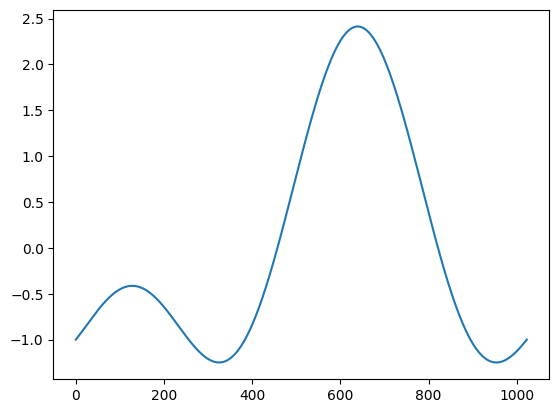

In [471]:
plt.plot(g_h)

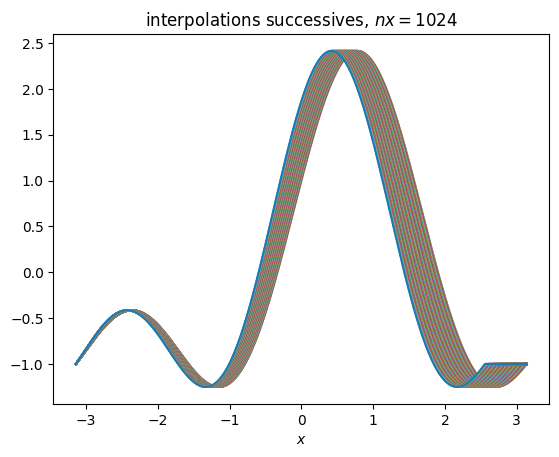

In [472]:
err_l2 = [] 

plt.plot(x, g_h)
plt.xlabel(r'$x$')
plt.title(r'interpolations successives, $nx=${}'.format(nx))


for i in range(100):
    c = fourier_coeffs(x, k_values, g_h)
    _int = fourier_interpolator(x, k_values, c)
    new_g = np.array(list(map(_int, x))) 
    s = np.sum(np.abs(g_h-new_g)**2)**0.5
    err_l2.append(s**0.5)
    plt.plot(x, new_g) 
    g_h = new_g 

plt.savefig('./graphs/interpolations_nx={}.png'.format(nx))
    


In [339]:
len(int_x) == nv 
len(int_v) == nx 

True

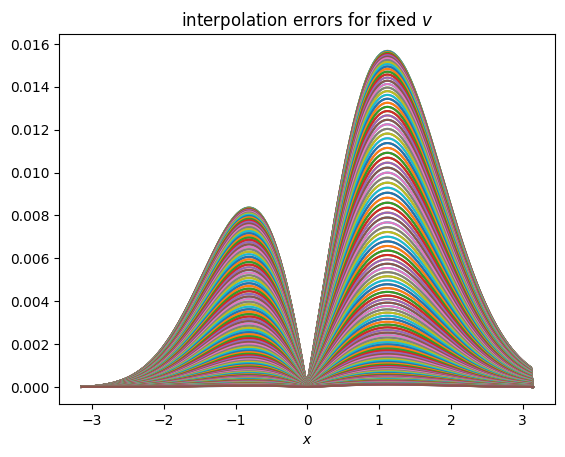

In [340]:
for i, _int in enumerate(int_x):
    rec = np.array(list(map(_int, x)))
    plt.plot(x, np.abs(rec-f_zero[i,:]))
    plt.title(r'interpolation errors for fixed $v$')
    plt.xlabel(r'$x$')

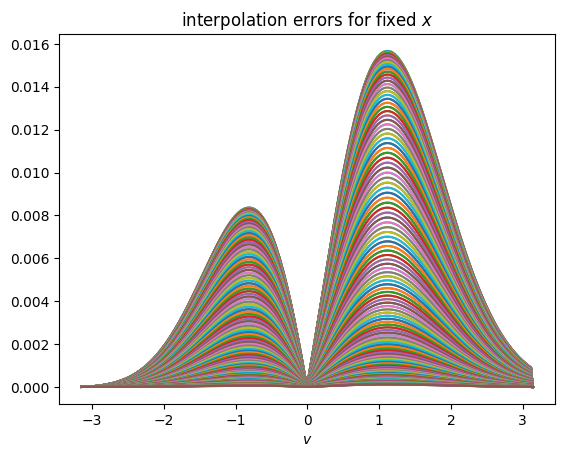

In [341]:
for j, _int in enumerate(int_v):
    rec = np.array(list(map(_int, v)))
    plt.title(r'interpolation errors for fixed $x$')
    plt.plot(v, np.abs(rec-f_zero[:,j]))
    plt.xlabel(r'$v$')

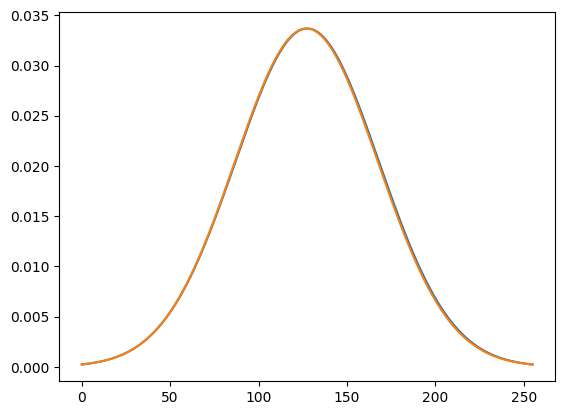

In [211]:
plt.plot(f_zero[15,:])
plt.plot(list(map(int_x[15], x)))

In [212]:
_x = np.linspace(-4*np.pi, 4*np.pi, 4*nx)
extended_int = list(map(int_x[15], _x))

## L'interpolation périodise la solution 

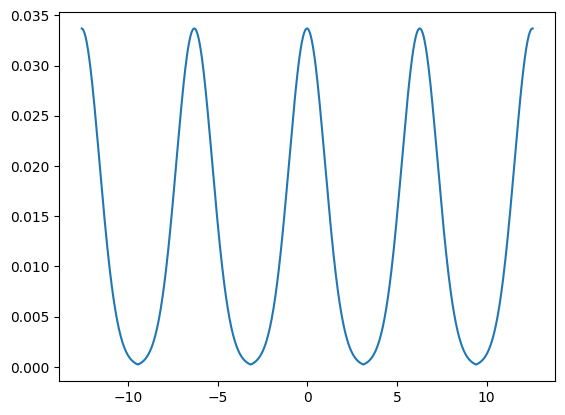

In [213]:
plt.plot(_x, extended_int) 

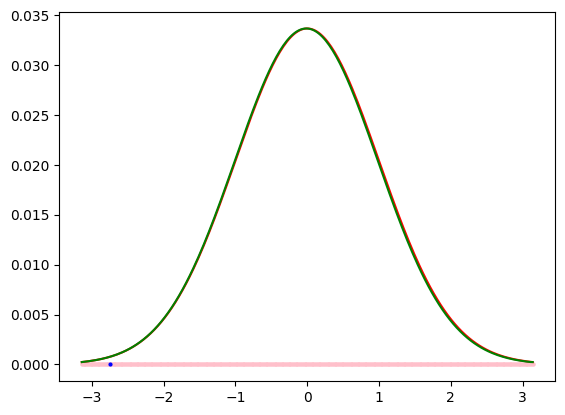

In [214]:
plt.scatter(x, np.zeros(nx), c='pink', s=5)
plt.scatter(x[15] - v[15]*0.01, 0, c='blue', s=4)
plt.plot(x, f_zero[15,:], c='red')
plt.plot(x, list(map(int_v[15], x)), c='green')

## Code pour l'advection 

In [342]:
def local_x_advection(x, v, f, i, j, time_step, interpolators):
    _x = x[j]; _v = v[i] 
    x_tilde = _x - _v*time_step
    point = x_tilde 
    # # Test cases to enforce periodic boundary conditions 
    # if x_tilde < x[0]:
    #     # In case one steps out of the grid from the left 
    #     point = x[-1] - (x[0] - x_tilde) 
    # elif x_tilde > x[-1]:
    #     # In case one steps out of the grid from the right 
    #     point = x[0] + (x_tilde - x[-1])
    # else:
    #     point = x_tilde 
    # # interpolator for fixed v = v[i] 
    return np.real(interpolators[i](point)) 

def local_v_advection(x, v, f, i, j, time_step, _E, interpolators):
    _x = x[j]; _v = v[i] 
    E = np.real(_E[j])
    v_tilde = _v + E*time_step
    point = v_tilde 
    # # Test cases for periodic boundary conditions 
    # if v_tilde < v[0]:
    #     # In case one steps out of the grid from the left 
    #     point = v[-1] - (v[0] - v_tilde) 
    # elif v_tilde > v[-1]:
    #     # In case one steps out of the grid from the right 
    #     point = v[0] + (v_tilde - v[-1])
    # else:
    #     point = v_tilde 
    # interpolator for fixed x = x[j] 
    return np.real(interpolators[j](point)) 

def x_advection(x, v, k_values, f, time_step):
    nx = len(x) ; nv = len(v) 
    x_interpolators = build_x_interpolators(x, v, k_values, f)
    new_f = [
        local_x_advection(x, v, f, i, j, time_step, x_interpolators) 
        for i,j in np.ndindex((nv,nx))
    ]

    new_f = np.array(new_f).reshape((nv, nx)) 

    # new_f = np.array(new_f).reshape((nv-1, nx-1)) 
    # new_f = np.append(new_f, np.zeros((nv-1, 1)), axis=1) 
    # new_f = np.append(new_f, np.zeros((1, nx)), axis=0)
    # # v periodic BC 
    # new_f[-1,:] = new_f[0,:]
    # # x periodic BC 
    # new_f[:,-1] = new_f[:,0] 
    return new_f 

def v_advection(x, v, l_values, f, time_step, _E):
    nx = len(x) ; nv = len(v) 
    v_interpolators = build_v_interpolators(x, v, l_values, f) 
    new_f = [
        local_v_advection(x, v, f, i, j, time_step, _E, v_interpolators) 
        for i,j in np.ndindex((nv,nx))
    ]

    new_f = np.array(new_f).reshape((nv,nx)) 

    # new_f = np.array(new_f).reshape((nv-1, nx-1)) 
    # new_f = np.append(new_f, np.zeros((nv-1, 1)), axis=1) 
    # new_f = np.append(new_f, np.zeros((1, nx)), axis=0)
    # # v periodic BC 
    # new_f[-1,:] = new_f[0,:]
    # # x periodic BC 
    # new_f[:,-1] = new_f[:,0] 
    return new_f 

In [343]:
f_one = x_advection(x, v, k_values, f_zero, 1) 

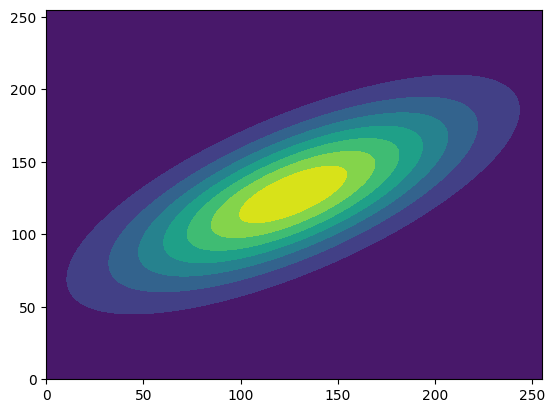

In [344]:
plt.contourf(f_one) 
E_one = solve_poisson(x, v, f_one) 

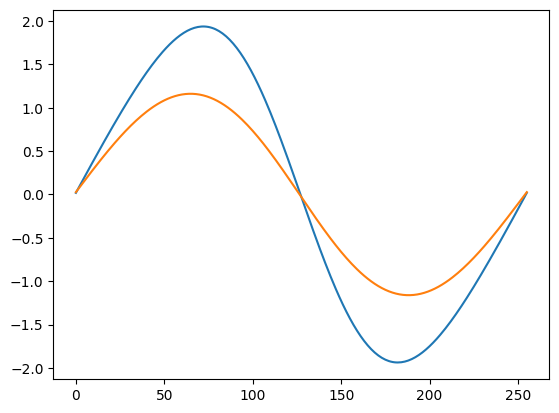

In [345]:
plt.plot(np.real(E_zero))
plt.plot(np.real(E_one)) 

In [346]:
f_two = v_advection(x, v, l_values, f_one, 1, E_one) 

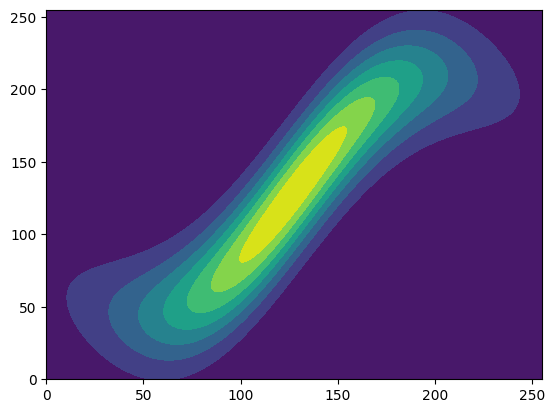

In [347]:
plt.contourf(f_two)

In [348]:
f_three = x_advection(x, v, k_values, f_two, 1) 

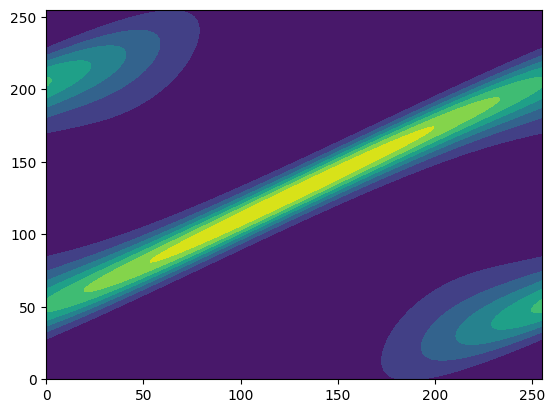

In [349]:
plt.contourf(f_three)
E_three = solve_poisson(x, v, f_three) 

In [ ]:
f_four = v_advection(x, v, l_values, f_three, 1, E_three)

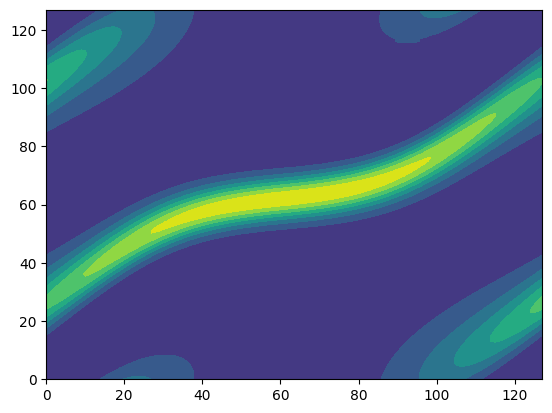

In [ ]:
plt.contourf(f_four) 

In [ ]:
def advection_step(x, v, k_values, l_values, f, _E, time_step):
    nx = len(x); nv = len(v)
    c = fourier_coeffs_2D(x, v, k_values, l_values, f) 
    interpol = fourier_interpolation_2D(x, v, k_values, l_values, c) 
    # print("interpolation and fourier coeffs computed")
    inter_points = [(x[n] - time_step*v[m], v[m] + time_step*np.real(_E)[n])
        for n,m in np.ndindex((nx,nv))]
    # print("inter points computed") 
    f_star_two = list(map(interpol, inter_points))
    f_star_two = np.array(f_star_two).reshape((nx,nv)).transpose() 
    # print("f** computed") 
    # new_E = solve_poisson(x, v, f_star_two)
    # print("Poisson solved") 
    # c_two = fourier_coeffs_2D(x, v, k_values, l_values, f_star_two) 
    # interpol_two = fourier_interpolation_2D(x, v, k_values, l_values, c_two)
    # inter_points_two = [(x[i], v[j] + 0.5*time_step*_E[i])
    #     for i,j in np.ndindex((nx, nv))]
    # print("inter points computed") 
    # new_f = list(map(interpol_two, inter_points_two))
    # new_f = np.array(new_f).reshape((nx,nv)).transpose() 
    # print("new f computed") 
    new_f = f_star_two
    return new_f

In [ ]:
# f_one, E_one = advection_step(x, v, k_values, l_values, f_zero, E_zero, time_step=0.01) 

In [ ]:
f_one = x_advection(x, v, k_values, f_zero, time_step=10)

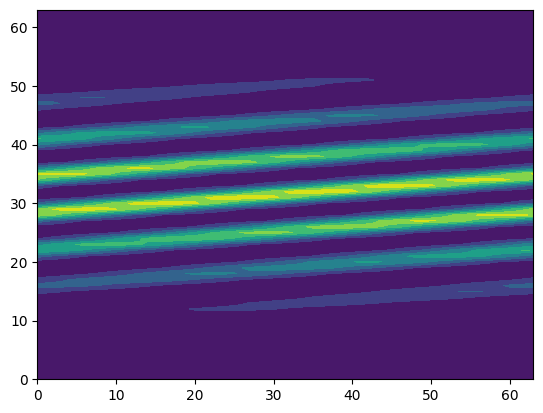

In [130]:
plt.contourf(f_one)

In [135]:
f_two = v_advection(x, v, l_values, f_zero, 20, E_zero)

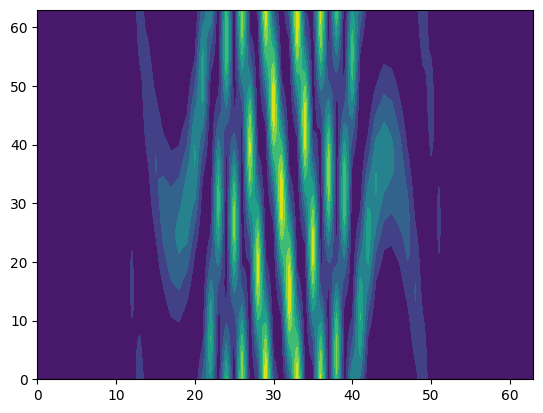

In [136]:
plt.contourf(f_two) 

## Code du schéma de splitting semi-lagrangien

In [220]:
class semi_lagrangian_solver():

    def __init__(self, nx, nv, K, L, dt, a, vmax):
        self.dt = dt 
        self.nx = nx 
        self.nv = nv
        self.K = K 
        self.k_values = np.arange(-K//2, K//2) 
        self.L = L 
        self.l_values = np.arange(-L//2, L//2) 
        self.a = a 
        self.vmax = vmax
        self.x = np.linspace(-a, a, nx)
        self.v = np.linspace(-vmax, vmax, nv)  
        self.dx = 2*a / nx 
        self.dv = 2*vmax / nv 
        self._E = None 
        self.f_zero = None 
        self.f = None 
        self.solutions = []
        self.electric_fields = [] 

    def initialisation(self, f):
        xx, vv = np.meshgrid(self.x, self.v)
        self.f_zero = f(xx, vv)   


        ## SOLVING POISSON 
        _E_zero = solve_poisson(self.x, self.v, self.f_zero) 
        # _E_zero = solve_poisson_2D_noshift(self.x, self.v, k_values, l_values, self.f_zero) 
        # _E_zero = solve_poisson_centered(self.x, self.dx, self.dv, self.f_zero)
        
        self._E = _E_zero 
        self.f = self.f_zero 
        self.solutions.append(self.f_zero)
        self.electric_fields.append(_E_zero)

    def solve(self, n_steps):  
        for i in range(n_steps):
            ## We change the scheme, replacing the half v advection with half x advection 
            ## Strang Splitting 
            # f_star = x_advection(self.x, self.v, self.k_values, self.f, 0.5*self.dt)
            # f_star_two = v_advection(self.x, self.v, self.l_values, f_star, self.dt, self._E) 
            # new_E = solve_poisson(self.x, self.v, self.k_values, f_star_two)
            # new_f = x_advection(self.x, self.v, self.k_values, f_star_two, 0.5*self.dt)

            f_star = v_advection(self.x, self.v, self.l_values, self.f, 0.5*self.dt, self._E)
            # f_star = v_advection(self.x, self.v, self.l_values, self.f, self.dt, self._E)
            f_star_two = x_advection(self.x, self.v, self.k_values, f_star, self.dt) 

            ## SOLVING POISSON 
            # new_E = solve_poisson_2D_noshift(self.x, self.v, self.k_values, self.l_values, f_star_two) 
            # new_E = solve_poisson(self.x, self.v, f_star_two)
            new_E = solve_poisson(self.x, self.v, f_star)
            # new_E = solve_poisson_centered(self.x, self.dx, self.dv, f_star_two)

            ## ADV WITH 2D INTERPOLATION 
            # new_f, new_E = advection_step(
            #     self.x, 
            #     self.v, 
            #     self.k_values, 
            #     self.l_values, 
            #     self.f,
            #     self._E, 
            #     self.dt
            # )

            new_f = v_advection(self.x, self.v, self.l_values, f_star_two, 0.5*self.dt, new_E) 

            ## To try only transport with a fixed electric field 
            # new_f = x_advection(self.x, self.v, self.k_values, self.f, self.dt)
            # new_E = self._E

            # new_f = f_star 
            
            self.f = new_f 
            self._E = new_E
            self.solutions.append(new_f) 
            self.electric_fields.append(new_E)
    
    def save_solutions(self, dir):
        for i, f in enumerate(self.solutions):
            plt.contourf(self.x, self.v, f)
            plt.xlabel(r'$x$'); plt.ylabel(r'$v$') 
            plt.title(r"$f$ at t={} s".format(i*self.dt))
            plt.savefig(dir + "f_{:03d}.png".format(i)) 
    
    def plot_electric_field(self):
        fig, ax = plt.subplots()
        for i, _E in enumerate(self.electric_fields):
            ax.plot(self.x, _E)
            ax.set_xlabel(r'$x$')

    def save_electric_field(self, dir): 
        for i, _E in enumerate(self.electric_fields):
            plt.plot(self.x, _E)
            plt.xlabel(r'$x$')
            plt.title(r"$E$ at t={}s".format(i*self.dt))
            plt.savefig(dir + "E_{:03d}.png".format(i))
    
    def track_dominant_fourier_mode(self): 
        self.dominant_mode = [] 
        for _E in self.electric_fields:
            c = np.abs(np.fft.fft(_E)) 
            c.sort() 
            self.dominant_mode.append(c[-1]) 
        

In [221]:
N = 2**7
solver = semi_lagrangian_solver(
    nx=N,
    nv=N, 
    K=N, 
    L=N, 
    dt=0.01, 
    a=np.pi, 
    vmax=np.pi
)

In [351]:
dx = 2*np.pi / nx 
dx

0.02454369260617026

In [354]:
2**7


128

In [77]:
sigma_v = 0.3

In [78]:
f_landau = lambda x,v : (1+0.001*np.cos(x)) * (1/(2*sigma_v*(2*np.pi)**0.5)) * np.exp(-0.5 * sigma_v**-2 * v**2)

In [79]:
k = 0.5; v_0 = 1
sigma_v = 0.3

In [80]:
f_instability = lambda x,v : (1+0.001*np.cos(k*x)) * (1/(2*sigma_v*(2*np.pi)**0.5)) * (np.exp(-0.5 * sigma_v**-2 * (v-v_0)**2) + np.exp(-0.5 * sigma_v**-2 * (v+v_0)**2))

In [222]:
solver.initialisation(f) 

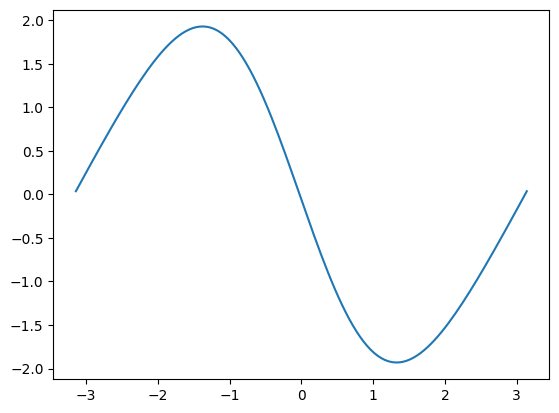

In [223]:
plt.plot(solver.x, np.real(solver._E))

In [ ]:
# f_one, E_one = advection_step(
#     solver.x,
#     solver.v,
#     solver.k_values,
#     solver.l_values,
#     solver.f_zero, 
#     solver._E,
#     solver.dt
#     )

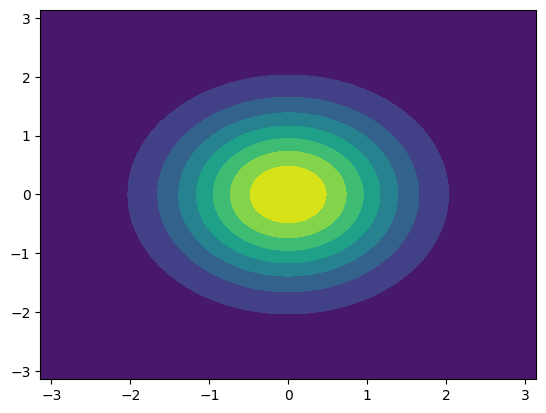

In [224]:
plt.contourf(solver.x, solver.v, solver.f_zero)

In [225]:
n = 50
solver.solve(n_steps = n) 

In [226]:
len(solver.solutions)

51

In [227]:
len(solver.electric_fields)

51

In [162]:
solver.track_dominant_fourier_mode() 

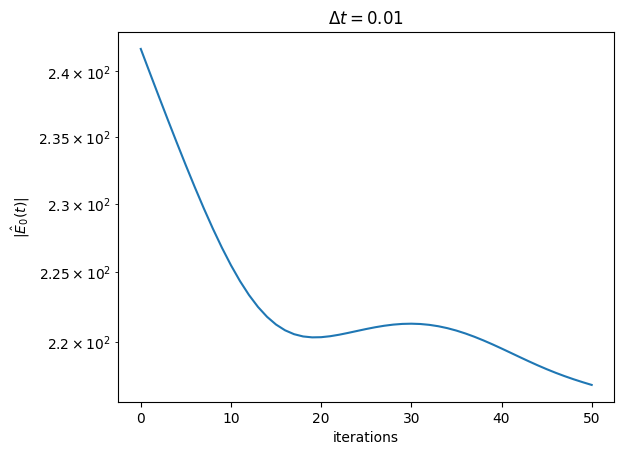

In [163]:
fig, ax = plt.subplots() 

plt.title(r'$\Delta t=0.01$')

ax.set_yscale('log')
ax.plot(solver.dominant_mode)
ax.set_ylabel(r'$|\hat{E}_{0}(t)|$')
ax.set_xlabel('iterations') 

plt.savefig('./graphs/fourier/fourier_mode_dirichlet_n={}.png'.format(n))

In [164]:
solver.dt 

0.1

In [228]:
import matplotlib.animation as animation 

In [229]:
writergif = animation.PillowWriter(fps=10) 

/home/murloc/.local/lib/python3.10/site-packages/numpy/ma/core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


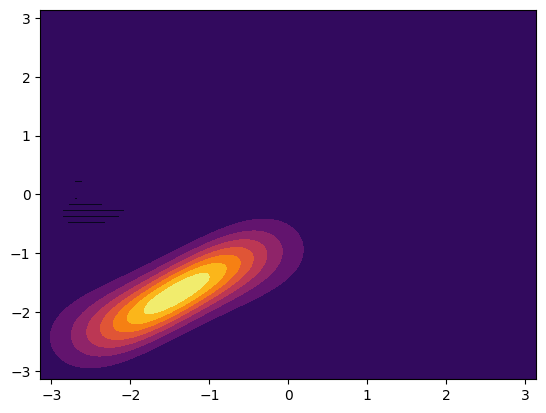

In [230]:
fig, ax = plt.subplots() 
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$v$')

def animate(i):
    ax.clear() 
    ax.contourf(solver.x, solver.v , solver.solutions[i], cmap='inferno')
    return 

anim = animation.FuncAnimation(fig, animate, frames=n, interval=200, repeat=True)  
anim.save('graphs/fourier/distrib_maxwell_n={}.gif'.format(n), writer=writergif)
plt.show() 

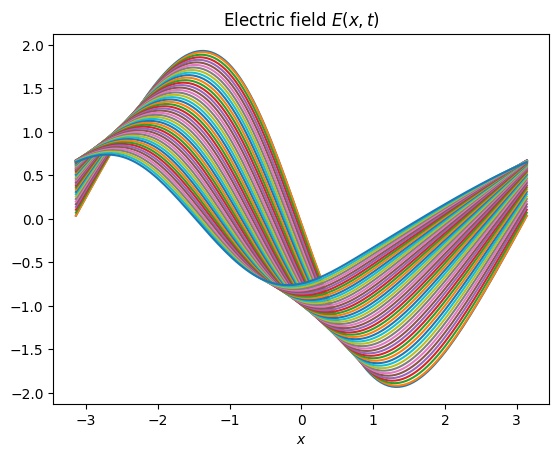

In [231]:
for i, _E in enumerate(solver.electric_fields):
    plt.plot(solver.x, np.real(_E)) 
    plt.xlabel(r'$x$')
    plt.title(r'Electric field $E(x,t)$') 